# Reference code: JAK2 activity optimization with ReLeaSE algorithm

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import numpy as np
import pandas as pd
import selfies as sf
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [5]:
from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData, normalize_SMILES

## Setting up the generator

### Loading data for the generator

In [6]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'zinc15')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_1_pretraining_ReBADD', 'zinc15')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [7]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 599957
Number of vocabulary: 44766
Maximum of seqlen: 44


## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

Initialize stack-augmented generative RNN:

In [8]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 44,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 0.001,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [9]:
my_generator = StackAugmentedVAE(**kwargs_generator)

If you want train the model from scratch, uncomment the lines below:

In [10]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.txt')

In [11]:
losses = my_generator.fit(gen_data, n_iterations=15000,
                          batch_size=32,
                          print_every=1000,
                          ckpt_every=1000,
                          model_path=model_path,
                          losses_path=losses_path)

Training in progress...:   7%|▋         | 999/15000 [25:34<6:04:18,  1.56s/it]

[01000 (6.7%) 25m 36s], Loss_vae:3.248, Loss_rec:3.121, Loss_kld:7.124, Beta:0.067
selfies: [C][O][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][C][C][=C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][C][=Branch1][C][=S][N][C][=C][C][=C][Branch1][C][F][C][=Branch1][Ring2][=C][Ring1][#Branch1][C][Branch1][C][F][Branch1][C][F][F]
smiles: COC1=CC=CC(=C1)CC=C(C2=CC=CC=C2)OCC(=S)NC3=CC=C(F)C(=C3)C(F)(F)F


Training in progress...:  13%|█▎        | 1999/15000 [51:13<5:36:59,  1.56s/it]

[02000 (13.3%) 51m 15s], Loss_vae:2.342, Loss_rec:2.287, Loss_kld:0.626, Beta:0.133
selfies: [=Branch1][=Branch1][=C][Ring1][=N][Ring1][=Branch2][C][C][S][C][C][=Branch1][C][=O][N][C][C][=C][C][=C][N][=C][Ring1][=Branch1][O]
smiles: CCCSCC(=O)NCC1=CC=CN=C1O


Training in progress...:  20%|█▉        | 2999/15000 [1:16:50<5:11:08,  1.56s/it]

[03000 (20.0%) 76m 51s], Loss_vae:2.135, Loss_rec:2.114, Loss_kld:0.131, Beta:0.200
selfies: [C][C][C][S][C][=N][N][=C][Branch1][Ring2][S][Ring1][Branch1][N][C][=Branch1][C][=O][C][C][C][N][Branch1][Branch1][C][C][Ring1][=Branch1][S][=Branch1][C][=O][=Branch1][C][=O][C][C][=C][Branch1][C][F][C][=C][C][=C][Ring1][#Branch1][Cl]
smiles: CCCSC1=NN=C(S1)NC(=O)C2CCN(CC2)S(=O)(=O)CC3=C(F)C=CC=C3Cl


Training in progress...:  27%|██▋       | 3999/15000 [1:42:25<4:46:17,  1.56s/it]

[04000 (26.7%) 102m 27s], Loss_vae:2.037, Loss_rec:2.016, Loss_kld:0.091, Beta:0.267
selfies: [C][C][O][C][=Branch1][C][=O][C][=C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][N][=C][S][C][Branch2][Ring1][=Branch1][C][=Branch1][C][=O][N][Ring1][=Branch1][C][Ring1][=C][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1][=C][C][=C][C][=C][Branch1][=Branch2][C][Branch1][Ring1][O][C][=C][Ring1][Branch2][O][C][C][O][C][=C][C][Branch1][C][C][=C][C][=C][Ring1][#Branch1][C]
smiles: CCOC(=O)C1=C(C(F)(F)F)N=C2SC(C(=O)N2C1C3=CC=C(Cl)C=C3)=CC4=CC=C(C(OC)=C4)OCCOC5=CC(C)=CC=C5C


Training in progress...:  33%|███▎      | 4999/15000 [2:07:58<4:13:09,  1.52s/it]

[05000 (33.3%) 127m 59s], Loss_vae:1.962, Loss_rec:1.939, Loss_kld:0.078, Beta:0.333
selfies: [C][C][N][C][=Branch2][Ring1][=Branch1][=N][N][=C][Ring1][Branch1][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][S][C][Branch1][=Branch1][C][Branch1][C][O][=O][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=Branch1][C][=O][C][S][C][=C][C][Branch1][C][Cl][=C][C][Branch1][C][Cl][=C][Ring1][Branch2]
smiles: CCN1C(=NN=C1C2=CC(OC)=CC(OC)=C2)SC(C(O)=O)=CC3=CC=CC=C3OC(=O)CSC4=CC(Cl)=CC(Cl)=C4


Training in progress...:  40%|███▉      | 5999/15000 [2:33:31<3:53:41,  1.56s/it]

[06000 (40.0%) 153m 33s], Loss_vae:1.911, Loss_rec:1.885, Loss_kld:0.071, Beta:0.400
selfies: [C][C][=C][C][=Branch1][#Branch1][=C][C][=C][Ring1][=Branch1][Cl][O][C][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][=N][C][=Branch1][Branch1][=N][NH1][Ring1][Branch1][N][C][=C][C][=C][Branch1][=Branch1][O][C][O][Ring1][Branch1][C][=C][Ring1][=Branch2][Cl]
smiles: CC1=CC(=CC=C1Cl)OCC2=CC=C(C=C2)C3=NC(=N[NH1]3)NC4=CC5=C(OCO5)C=C4Cl


Training in progress...:  47%|████▋     | 6999/15000 [2:59:05<3:24:45,  1.54s/it]

[07000 (46.7%) 179m 7s], Loss_vae:1.883, Loss_rec:1.854, Loss_kld:0.068, Beta:0.467
selfies: [C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=S][N][C][Branch1][=Branch2][C][=C][C][=C][C][=N][Ring1][=Branch1][C][Ring1][N][C][=C][C][=C][Branch1][Ring2][O][Ring1][Branch1][C][=C][C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][=C][C][=Branch1][Ring2][=C][Ring1][#Branch2][C][Branch1][C][F][Branch1][C][F][F]
smiles: CC1=CC=CC=C1N2C(=S)NC(C3=CC=CC=N3)C2C4=CC=C(O4)C5=CC(C(F)(F)F)=CC(=C5)C(F)(F)F


Training in progress...:  53%|█████▎    | 7999/15000 [3:24:41<3:02:41,  1.57s/it]

[08000 (53.3%) 204m 43s], Loss_vae:1.865, Loss_rec:1.832, Loss_kld:0.065, Beta:0.533
selfies: [O][=C][=Branch1][=Branch2][=C][C][=C][Ring1][=Branch1][Ring2][Ring1][P][O][C][C][=Branch1][C][=O][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][S][Ring1][#Branch2][=Branch1][C][=O][=O]
smiles: O=C(CC=C)OCC(=O)C1=CC=C(C=C1)N2C(=O)C3=CC=CC=C3S2(=O)=O


Training in progress...:  60%|█████▉    | 8999/15000 [3:50:17<2:32:10,  1.52s/it]

[09000 (60.0%) 230m 19s], Loss_vae:1.844, Loss_rec:1.808, Loss_kld:0.063, Beta:0.600
selfies: [C][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][S][=Branch1][C][=O][=Branch1][C][=O][C][C][=Branch1][C][=O][N][Branch1][=N][C][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1][C][Branch1][Branch2][C][=C][C][=C][S][Ring1][Branch1][C][=Branch1][C][=O][N][C][C][C][C][C][Ring1][Branch1]
smiles: CC1=CC=C(C=C1)S(=O)(=O)CC(=O)N(CC2=CC=C(Cl)C=C2)C(C3=CC=CS3)C(=O)NC4CCCC4


Training in progress...:  67%|██████▋   | 9999/15000 [4:15:46<2:06:00,  1.51s/it]

[10000 (66.7%) 255m 48s], Loss_vae:1.839, Loss_rec:1.800, Loss_kld:0.062, Beta:0.667
selfies: [C][O][C][=C][C][=Branch2][Ring1][Ring1][=C][C][=C][Ring1][=Branch1][O][C][C][=C][C][=C][C][Branch1][C][C][=C][Ring1][#Branch1][C][=C][C][=Branch1][C][=N][N][N][=C][Branch1][=Branch2][C][=C][C][=C][N][=C][Ring1][=Branch1][S][C][Ring1][O][=N][C][Ring1][S][=O]
smiles: COC1=CC(=CC=C1OCC2=CC=CC(C)=C2)C=C3C(=N)N4N=C(C5=CC=CN=C5)SC4=NC3=O


Training in progress...:  73%|███████▎  | 10999/15000 [4:41:15<1:46:29,  1.60s/it]

[11000 (73.3%) 281m 17s], Loss_vae:1.828, Loss_rec:1.785, Loss_kld:0.061, Beta:0.733
selfies: [C][C][=C][Branch1][=C][C][=Branch1][C][=O][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][N][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1][N][C][=Branch1][Branch1][=N][Ring2][Ring1][=Branch1][S][C][Branch1][Branch1][C][Ring1][=Branch1][=O][=C][C][=C][C][=C][Branch1][C][C][C][=C][Ring1][#Branch1][Br]
smiles: CC1=C(C(=O)NC2=CC=CC=C2)C(C3=CC=C(Cl)C=C3)N4C(=N1)SC(C4=O)=CC5=CC=C(C)C=C5Br


Training in progress...:  80%|███████▉  | 11999/15000 [5:06:49<1:16:08,  1.52s/it]

[12000 (80.0%) 306m 51s], Loss_vae:1.821, Loss_rec:1.774, Loss_kld:0.060, Beta:0.800
selfies: [C][C][C][N][C][=Branch1][C][=O][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Branch1][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1][Cl][C][=Branch1][C][=O][C][O][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1][Br]
smiles: CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC=C2Cl)C(=O)COC3=CC=C(Cl)C=C3Br


Training in progress...:  87%|████████▋ | 12999/15000 [5:32:24<51:45,  1.55s/it]  

[13000 (86.7%) 332m 25s], Loss_vae:1.813, Loss_rec:1.763, Loss_kld:0.060, Beta:0.867
selfies: [C][C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][=Branch2][Ring1][Branch1][=C][Branch1][Branch1][C][=Ring1][Branch1][C][C][=Branch1][C][=O][N][C][=C][C][=C][C][=C][Ring1][=Branch1][Branch1][#Branch2][C][=Branch1][C][=O][C][C][C][Ring1][Ring1][=C][Ring1][#Branch2][Br]
smiles: CCOC1=CC2=CC=C1C2=O


Training in progress...:  93%|█████████▎| 13999/15000 [5:57:57<25:28,  1.53s/it]

[14000 (93.3%) 357m 58s], Loss_vae:1.815, Loss_rec:1.761, Loss_kld:0.060, Beta:0.933
selfies: [C][O][C][=Branch1][C][=O][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][N][C][=Branch1][C][=O][C][S][C][=N][N][=C][Branch1][N][N][Ring1][Branch1][C][C][=C][C][=C][O][Ring1][Branch1][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][Branch1][C][C][Branch1][C][C][C]
smiles: COC(=O)C1=CC=C(C=C1)NC(=O)CSC2=NN=C(N2CC3=CC=CO3)C4=CC=C(C=C4)C(C)(C)C


Training in progress...: 100%|█████████▉| 14999/15000 [6:23:25<00:01,  1.50s/it]

[15000 (100.0%) 383m 27s], Loss_vae:1.811, Loss_rec:1.753, Loss_kld:0.060, Beta:1.000
selfies: [O][=C][C][C][S][C][=Ring1][#Branch1][N][C][=C][C][=C][Branch1][C][Br][C][=C][Ring1][#Branch1][C][=Branch1][C][=O][N][Branch1][C][C][C][=Branch1][C][=O][N][C][Ring2][Ring1][=Branch1][O]
smiles: O=CCCSCNC1=CC=C(Br)C=C1C(=O)N(C)C(=O)NCO


Training in progress...: 100%|██████████| 15000/15000 [6:23:27<00:00,  1.53s/it]


In [12]:
my_generator.save_model(model_path)

In [13]:
with open(losses_path, 'w') as fout:
    fout.write("LOSS_VAE\tLOSS_RECONSTRUCTION\tLOSS_KLDIVERGENCE\tBETA\n")
    for loss_vae, loss_rec, loss_kld, beta in zip(losses['LOSS_VAE'], losses['LOSS_RECONSTRUCTION'], losses['LOSS_KLDIVERGENCE'], losses["BETA"]):
        fout.write(f"{loss_vae:.6f}\t{loss_rec:.6f}\t{loss_kld:.6f}\t{beta:.3f}\n")

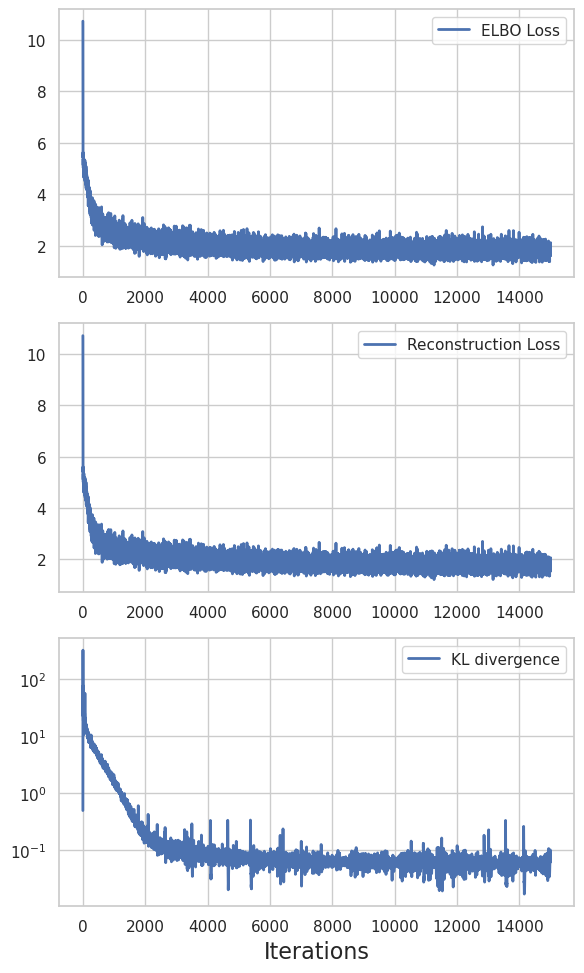

In [14]:
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(3,1,figsize=(6,9.9))

axes[0].plot(losses['LOSS_VAE'], label='ELBO Loss', linewidth=2)
axes[1].plot(losses['LOSS_RECONSTRUCTION'], label='Reconstruction Loss', linewidth=2)
axes[2].plot(losses['LOSS_KLDIVERGENCE'], label='KL divergence', linewidth=2)

#ax.set_ylabel('Loss', fontsize=16)
axes[2].set_xlabel('Iterations', fontsize=16)

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')

axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

In [15]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        sel = generator.evaluate(gen_data)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = normalize_SMILES(sf.decoder(sel))
        generated.append(smi)
    return generated

In [16]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [17]:
n_sampling = 30000

smi_after = SMILES_generate(my_generator, n_sampling, gen_data)

100%|██████████| 30000/30000 [10:49<00:00, 46.16it/s]


In [18]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_1_pretraining_ReBADD/zinc15/smi_after.csv
